<b> Code Appendix <b>

In [1]:
#Appropriate Folder Setup

#1. Create two new folders specifically named 'Ham' and 'Spam'. At the end, these will be subfolders placed in the main 'Email' folder. 

#2. Download each zipfile for each subset of the data from https://spamassassin.apache.org/old/publiccorpus/

#3 Extract each zip file for each subset into the corresponding 'Ham' or 'Spam' folder, while ignoring the detection difficulty aspect of the subsets 

#4  Once all the data has been placed in the appropriate subfolder, create a new folder specifically titled "Email",  and place the two 
#subfolders into the 'Email' folder. 

#5 You guys must also run the following two lines of code once 
# nltk.download('punkt')
# nltk.download('stopwords')

#These download the Punkt tokenizer models, as well as a collection of stopwords, and are both essential resources for NLTK (Natural Language Toolkit)


In [2]:
# Step 1: Importing Neccesary 
import os #Importing os to navigate through the "Email" folder and get all files  
import pandas as pd
import nltk # Importing nltk, which is used a lot for preprocessing the data
from nltk.stem.porter import PorterStemmer #Importing PorterStemmer, used for "stemming" or reducing words to their base
from nltk.corpus import stopwords 
import string
from collections import Counter # Importing counter function for when we need to get most common words from  both Ham and Spam emails
from bs4 import BeautifulSoup #Importing BeautifulSoup to extract HTML content that we won't want to include in our "content" variable


# NEED to run these next 2 lines of code below ONCE to tokenize the text, and remove stopwords (words like "and",or "the" that aren't meaningful)
nltk.download('punkt')
nltk.download('stopwords')


#STEP 1: (Preprocessing) Stemming the words to 

#Initializing the PorterStemmer, used for "stemming" or reducing words to their base. Enables matching between diff types of same word 
#(ex: running, ran, runner all reduced to run). Once we have this, we can use "ps.stem()" later on 
ps = PorterStemmer()



#Function for preprocessing text, which standardizes text (LOWERCASING, TOKENIZING, REMOVING USELESS TEXT). Standardization ALSO
#enables matching of different types of same word. 
def transform_text(text):
    # Transforming all text to lowercase (so all variations of a given word are considered the same)
    text = text.lower()
    
    # Tokenizing using nltk, which helps structure the text, specifically since 
    text = nltk.word_tokenize(text)
    
    # Starting stopword removal process by by iterating through the token, and appending to empty list all alphanumeric values
    #alphanumeric values include words we will want to keep, as well as stopwords, which we don't want
    y = []
    for i in text: 
        if i.isalnum(): #"isalnum() selects all words that alphanumeric
            y.append(i)
            
    # Creating a set of words to exclude ('http' and 'https' are highly problematic and therefore undesired)
    exclude_words = set(['http', 'https'])
    
    #Copying all elements in y into a new object, "text"
    text = y[:]
    #Clearing y for now, but it will later be filled again, only with the words we want
    y.clear()
    
    for i in text:
        # Checking if the token is not in the list of stopwords for English provided by NLTK,and that its not punctuation or from exclude_words set
        if i not in stopwords.words('english') and i not in string.punctuation and i not in exclude_words:
            y.append(i) #Appending to y every token that passed the "if" condition 
        
    # Putting new list of desired words into 'text' object, clearing y again, and then stemming each element in 'text' before placing back into y
    #Purpose of this is to stemming the list of cleaned words to root form
    text = y[:]
    y.clear()
    for i in text:
        #
        y.append(ps.stem(i))
    
    return " ".join(y)

# Cleaning HTML content within the emails, as the HTML content is widespread but not useful in any way
def extract_text_from_html(content):
    soup = BeautifulSoup(content, 'html.parser')
    return soup.get_text()

# Specify the directory containing the files
folder_path = "C:/Users/Zohd/Desktop/Email" 

# Initialize a list to keep track of files
all_files = []

# Going through the folder structure and appending to our list all files in the folder
for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        # Construct the full file path
        file_path = os.path.join(dirpath, filename)
        # Append the file path to the list
        all_files.append(file_path)
        
        #if len(all_files) >= 1000:
            #break
    #if len(all_files) >= 1000:
        #break

# Writing function to classify. This function checks if words 'spam' and 'ham' are in the folder path, and then returns either Spam text or Ham text in 
#string format 
def determine_classification(path):
    if 'spam' in path.lower():
        return 'Spam'
    elif 'ham' in path.lower():
        return 'Ham'
    else:
        return 'Unknown'


# This portion of the code is making use of the previously written functions, and applying these functions to the actual data we have stored.
# Our specific goals here are to extract the email bodies, handle the HTML emails, classify the emails, and storing the data into a dictionary 

# Initialize a list to store email data
email_data = []
cnt = 0
# Loop over each file path in the collected files
for file_path in all_files:
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()
            #cnt += 1 
            #if cnt == 3000:
                #break 
            # Find the start of the email body and extract it
            body_start_index = content.find("\n\n") + 2
            email_body = content[body_start_index:]
            
            # Check if the email is in HTML format and extract text
            if "<html" in email_body.lower():
                email_body = extract_text_from_html(email_body)

            #Applying "determine_classification" function from earlier to classify each email
            classification = determine_classification(file_path)

            
            #After having processed and classified each email, we are appending a dictionary to email_data list
            #This dictionary, which contains 'EmailBody' and 'Classification', simplifies the process of storing 
            #all our variables into Dataframe. 
            email_data.append({'EmailBody': email_body, 'Classification': classification})
    except Exception as e:
        print(f"Could not read {file_path}: {e}")

# Create the DataFrame from the list of dictionaries
emails_df = pd.DataFrame(email_data)

# Apply the transformation to each email body using "transform_text" function written earlier
emails_df['trfm_text'] = emails_df['EmailBody'].apply(transform_text)

# Analyze the most common words in 'ham' and 'spam' emails
selected_words_ham = []
for sentence in emails_df[emails_df['Classification'] == 'Ham']['trfm_text'].tolist(): #looping through all 'Ham' emails
    for word in sentence.split(): #for each word from the split of each sentence, appending to list of most selected words
        selected_words_ham.append(word)

selected_words_spam = []
for sentence in emails_df[emails_df['Classification'] == 'Spam']['trfm_text'].tolist(): # Repeating process from previous portion of code for "Spam"
    for word in sentence.split():
        selected_words_spam.append(word)

# Creating a DataFrame with the most common words and their counts for both 'ham' and 'spam'
swh_df = pd.DataFrame(Counter(selected_words_ham).most_common(30), columns=['Word', 'Frequency'])
sws_df = pd.DataFrame(Counter(selected_words_spam).most_common(30), columns=['Word', 'Frequency'])

#Printing the DataFrames to see the top words
print(swh_df)
print(sws_df)


      Word  Frequency
0      use       9480
1     list       6736
2      get       6320
3      one       6028
4     2002       5366
5     mail       5245
6     time       5015
7     like       5007
8    would       4843
9      new       4794
10  messag       4703
11    work       4430
12      mv       3908
13       1       3892
14    make       3867
15    file       3845
16   peopl       3652
17   wrote       3633
18    also       3284
19   email       3177
20    look       3057
21    date       3040
22   think       3028
23  system       3021
24   chang       3006
25     way       2995
26   could       2987
27    said       2970
28   group       2958
29      go       2956
       Word  Frequency
0     email       6212
1      free       5180
2     click       4153
3    receiv       3986
4      list       3953
5       get       3841
6        mv       3797
7     pleas       3708
8      busi       3578
9     order       3517
10     mail       3469
11    remov       3352
12  address       3

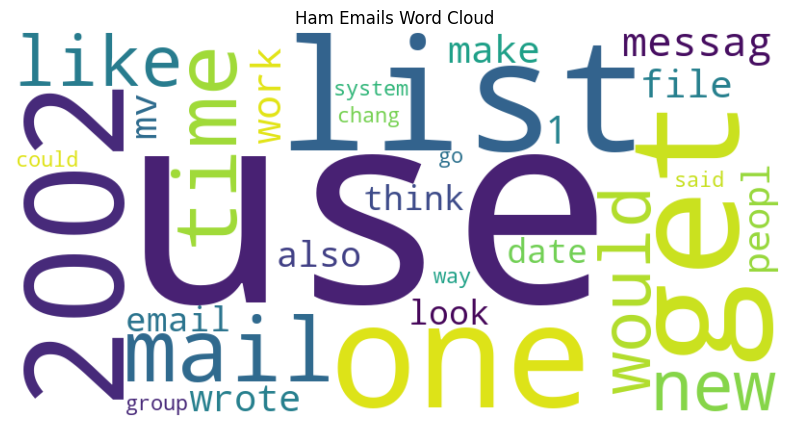

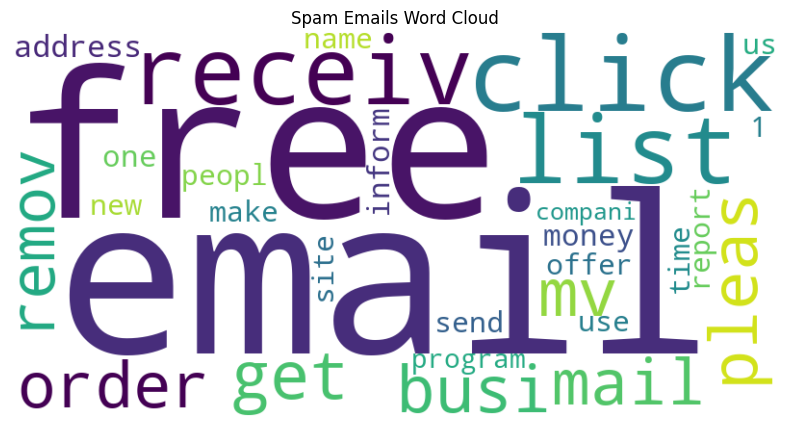

In [3]:
#Importing neccesary packages for WordCloud code
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Writing Function to generate a word cloud from the swh_df and sws_df Dataframes, respectively
def generate_wordcloud(dataframe, title):
    # Converting DataFrame to dictionary
    data_dict = dataframe.set_index('Word')['Frequency'].to_dict()
    
    # Initializing WordCloud object with apppropriate proportions 
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white')
    
    # Generate WordClouds
    wc.generate_from_frequencies(data_dict)
    
    # Plotting with appropriate measurements
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generating word cloud for 'ham' emails
generate_wordcloud(swh_df, 'Ham Emails Word Cloud')

# Generating word cloud for 'spam' emails
generate_wordcloud(sws_df, 'Spam Emails Word Cloud')


In [4]:
#Importing tokenizers
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')

# Writing Function to count total number of words in a text
def count_words(text):
    words = word_tokenize(text) #using function from nltk.tokenize to tokenize each word
    return len(words) #returning the length of "words"

# Writing Function to count total number of sentences in a text
def count_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

# Applying the functions to each email body and create new columns for word count and sentence count
emails_df['NumWords'] = emails_df['EmailBody'].apply(count_words)
emails_df['NumSentences'] = emails_df['EmailBody'].apply(count_sentences)

# Calculating total number of words for 'Spam' and 'Ham' emails separately
total_words_spam = emails_df[emails_df['Classification'] == 'Spam']['NumWords'].mean()
total_words_ham = emails_df[emails_df['Classification'] == 'Ham']['NumWords'].mean()
# Calculating total number of words for 'Spam' and 'Ham' emails separately
total_sentences_spam = emails_df[emails_df['Classification'] == 'Spam']['NumSentences'].mean()
total_sentences_ham = emails_df[emails_df['Classification'] == 'Ham']['NumSentences'].mean()
#Printing all of the results
print("Total Number of Words in Spam:", total_words_spam)
print("Total Number of Words in Ham:", total_words_ham)

print("Total Number of Sentences in Spam:", total_sentences_spam)
print("Total Number of Sentences in Ham:", total_sentences_ham)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zohd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total Number of Words in Spam: 457.2873321042929
Total Number of Words in Ham: 346.98674242424244
Total Number of Sentences in Spam: 19.043982091124573
Total Number of Sentences in Ham: 13.370791245791246


Text(0, 0.5, 'Mean Number of Sentences')

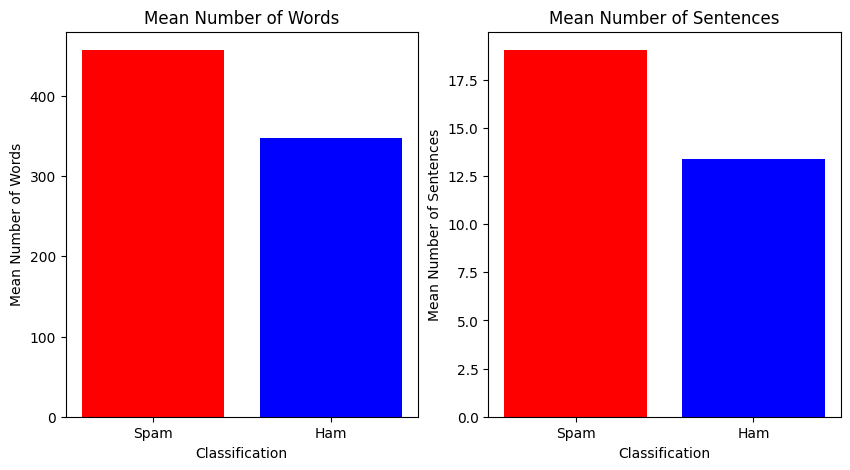

In [5]:
# Creating bar plots
plt.figure(figsize=(10, 5))

# Plotting mean number of words
plt.subplot(1, 2, 1)
plt.bar(['Spam', 'Ham'], [total_words_spam, total_words_ham], color=['red', 'blue'])
plt.title('Mean Number of Words')
plt.xlabel('Classification')
plt.ylabel('Mean Number of Words')

# Plotting mean number of sentences
plt.subplot(1, 2, 2)
plt.bar(['Spam', 'Ham'], [total_sentences_spam, total_sentences_ham], color=['red', 'blue'])
plt.title('Mean Number of Sentences')
plt.xlabel('Classification')
plt.ylabel('Mean Number of Sentences')


In [6]:
#Importing modules for getting various summary/important statistics
import re

# Calculate email body length
emails_df['EmailBodyLength'] = emails_df['EmailBody'].apply(len)

# Calculate number of links using regex pattern matching
emails_df['NumLinks'] = emails_df['EmailBody'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)))

# Calculate number of images using regex pattern matching
emails_df['NumImages'] = emails_df['EmailBody'].apply(lambda x: len(re.findall(r'<img [^>]*>', x)))

# Calculate mean email body length for 'Spam' and 'Ham' separately
total_email_body_length_spam = emails_df[emails_df['Classification'] == 'Spam']['EmailBodyLength'].mean()
total_email_body_length_ham = emails_df[emails_df['Classification'] == 'Ham']['EmailBodyLength'].mean()

# Calculate mean number of links using regex pattern matching for 'Spam' and 'Ham' separately
total_num_links_spam = emails_df[emails_df['Classification'] == 'Spam']['NumLinks'].mean()
total_num_links_ham = emails_df[emails_df['Classification'] == 'Ham']['NumLinks'].mean()

# Calculate mean number of images using regex pattern matching for 'Spam' and 'Ham' separately
total_num_images_spam = emails_df[emails_df['Classification'] == 'Spam']['NumImages'].mean()
total_num_images_ham = emails_df[emails_df['Classification'] == 'Ham']['NumImages'].mean()

# Print the total counts separately for 'Spam' and 'Ham'
print("Email Body Length for Spam:", total_email_body_length_spam)
print("Email Body Length for Ham:", total_email_body_length_ham)
print("Number of Links for Spam:", total_num_links_spam)
print("Number of Links for Ham:", total_num_links_ham)
print("Number of Images for Spam:", total_num_images_spam)
print("Number of Images for Ham:", total_num_images_ham)

Email Body Length for Spam: 3297.755069791941
Email Body Length for Ham: 1922.503787878788
Number of Links for Spam: 1.8617329470634711
Number of Links for Ham: 2.836910774410774
Number of Images for Spam: 0.04529892020015802
Number of Images for Ham: 0.00021043771043771043


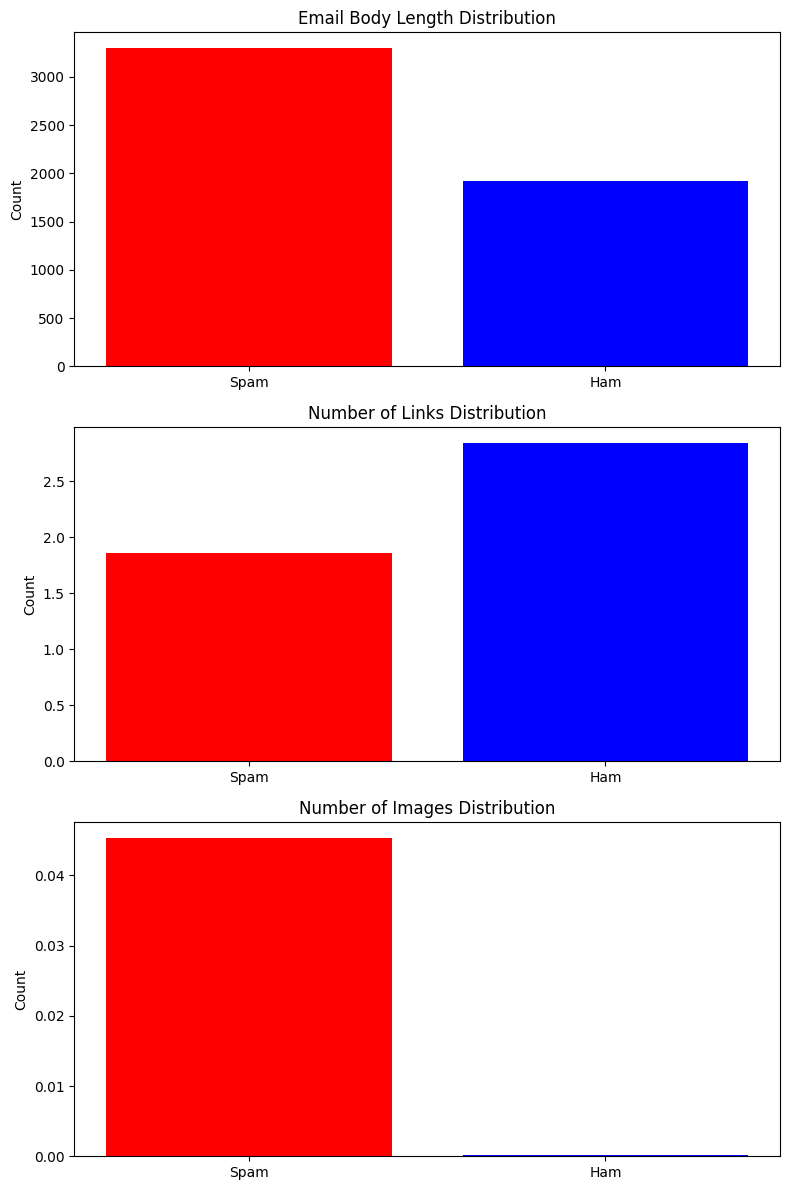

In [18]:
import matplotlib.pyplot as plt

#  Creating a dictionary for the Total counts for 'Spam' and 'Ham'
totals = {
    'Email Body Length': [total_email_body_length_spam, total_email_body_length_ham],
    'Number of Links': [total_num_links_spam, total_num_links_ham],
    'Number of Images': [total_num_images_spam, total_num_images_ham]
}


fig, axes = plt.subplots(3, 1, figsize=(8, 12))

for i, (feature, counts) in enumerate(totals.items()):
    ax = axes[i]
    ax.bar(['Spam', 'Ham'], counts, color=['red', 'blue'])
    ax.set_title(feature + ' Distribution')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

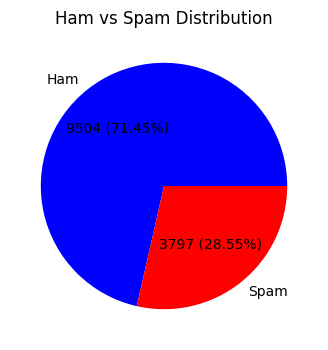

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Custom function for autopct that includes both count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct

# Get the counts for each classification
classification_counts = emails_df['Classification'].value_counts()

plt.figure(figsize=(6, 4))
# Specify the colors: first for 'Ham', second for 'Spam'
colors = ['blue', 'red']  
classification_counts.plot(kind='pie', autopct=make_autopct(classification_counts), colors=colors)

plt.title('Ham vs Spam Distribution')
plt.xticks([])
plt.ylabel('')  
plt.show()

In [13]:
from spellchecker import SpellChecker

# Initialize SpellChecker
spell_checker = SpellChecker()

# Function to count misspelled words in a text
def count_misspelled_words(text):
    # Tokenize the text
    words = text.split()
    # Find misspelled words
    misspelled_words = spell_checker.unknown(words)
    # Return the count of misspelled words
    return len(misspelled_words)

# Applying the functions to each email body and create new columns for misspelled words and grammar errors
emails_df['NumMisspelledWords'] = emails_df['EmailBody'].apply(count_misspelled_words)

# Calculating the frequency of misspelled words for spam and ham emails
misspelled_words_spam_freq = emails_df[emails_df['Classification'] == 'Spam']['NumMisspelledWords'].value_counts().sort_index()
misspelled_words_ham_freq = emails_df[emails_df['Classification'] == 'Ham']['NumMisspelledWords'].value_counts().sort_index()

# Printing the frequency of misspelled words for spam emails
print("Frequency of Misspelled Words in Spam Emails:")
print(misspelled_words_spam_freq)

# Printing the frequency of misspelled words for ham emails
print("\nFrequency of Misspelled Words in Ham Emails:")
print(misspelled_words_ham_freq)

Frequency of Misspelled Words in Spam Emails:
0       36
1       14
2       32
3       30
4       14
        ..
632      2
659      2
977      2
987      2
1463     2
Name: NumMisspelledWords, Length: 228, dtype: int64

Frequency of Misspelled Words in Ham Emails:
0         3
2        33
3        61
4        93
5       155
       ... 
1042      3
1409      1
2098      1
4615      1
5349      2
Name: NumMisspelledWords, Length: 297, dtype: int64


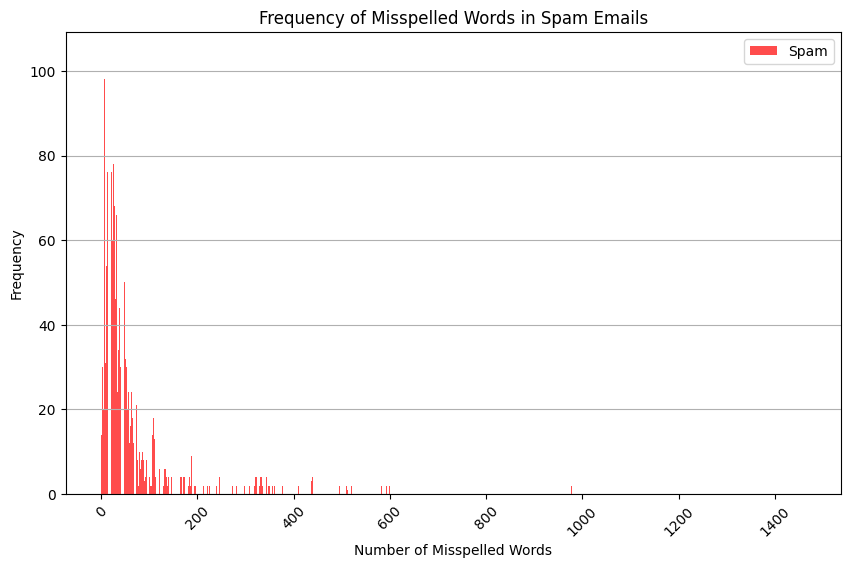

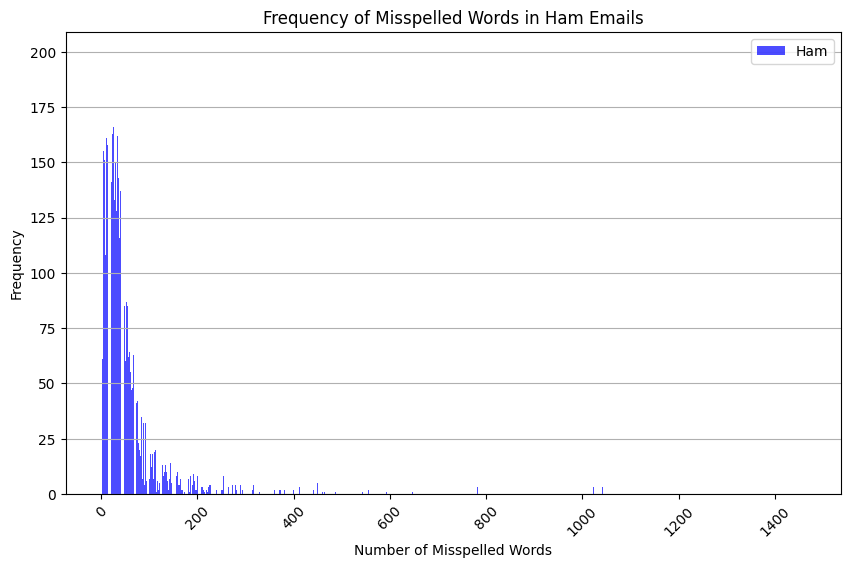

In [14]:
import matplotlib.pyplot as plt

# Determining the common range for the x-axis
common_range = range(min(misspelled_words_spam_freq.index.max(), misspelled_words_ham_freq.index.max()) + 1)

# Plotting the frequency of misspelled words for spam emails with standardized x-axis
plt.figure(figsize=(10, 6))
plt.bar(common_range, misspelled_words_spam_freq.reindex(common_range, fill_value=0), color='red', alpha=0.7, label='Spam')
plt.xlabel('Number of Misspelled Words')
plt.ylabel('Frequency')
plt.title('Frequency of Misspelled Words in Spam Emails')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.show()

# Plotting the frequency of misspelled words for ham emails with standardized x-axis
plt.figure(figsize=(10, 6))
plt.bar(common_range, misspelled_words_ham_freq.reindex(common_range, fill_value=0), color='blue', alpha=0.7, label='Ham')
plt.xlabel('Number of Misspelled Words')
plt.ylabel('Frequency')
plt.title('Frequency of Misspelled Words in Ham Emails')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

#Initializes TF-IDF Vectorizer with a limit of 3000 features to transform text data into a matrix of TF-IDF values.
# This process emphasizes words that are important and unique to documents, making it crucial for analyzing and classifying email content effectively.
tfidf = TfidfVectorizer(max_features=3000)
#Setting feature variable as matrix of TF-IDF values derived from our transformed text column
#Each row in X represents an email, and each column represents one of up to 3000 most important words across all emails based on TF-IDF scores
X = tfidf.fit_transform(emails_df['trfm_text']).toarray()
y = emails_df['Classification'].map({'Ham': 0, 'Spam': 1}).values
# Step 2: Splitting the data according to a standard 80-20 split into train and test sets, respectively, with a seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a dictionary of Models to train and this will be looped through later to perform CV and Model Predictions
models = {
    "Logistic Regression": LogisticRegression(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(), 
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Step 3: Training with cross-validation, and we are doing 5 fold cross validation for this
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
    accuracy = scores.mean()
    results[name] = accuracy

# Step 4: Displaying  the Results for cross-validation
print("\nCross-Validation:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

# Step 5: Training and evaluating models, by looping through respective key and value of dict, and performing standard fit, pred, results, etc.
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
   

# Step 6: Displaying Results for training model
print("\nModel performance summary:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")




C:\Users\Zohd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Zohd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Zohd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Zohd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Zohd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Cross-Validation:
Logistic Regression: 0.9772
LDA: 0.9682
QDA: 0.9702
Decision Tree: 0.9623
K-Nearest Neighbors: 0.8932
Random Forest: 0.9814
Bagging Classifier: 0.9613
Extra Trees: 0.9862
Gradient Boosting: 0.9457
XGBoost: 0.9738


C:\Users\Zohd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Model performance summary:
Logistic Regression: 0.9835
LDA: 0.9872
QDA: 0.9718
Decision Tree: 0.9846
K-Nearest Neighbors: 0.6490
Random Forest: 0.9947
Bagging Classifier: 0.9853
Extra Trees: 0.9951
Gradient Boosting: 0.9714
XGBoost: 0.9936


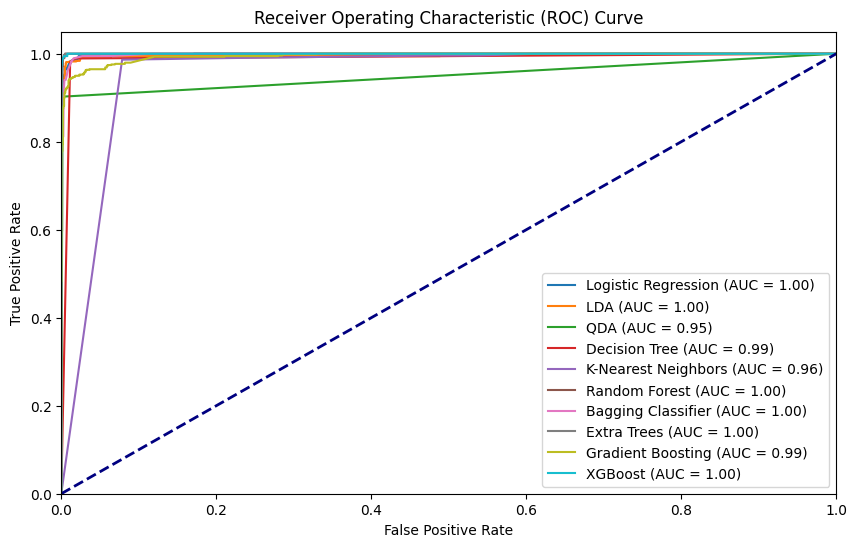

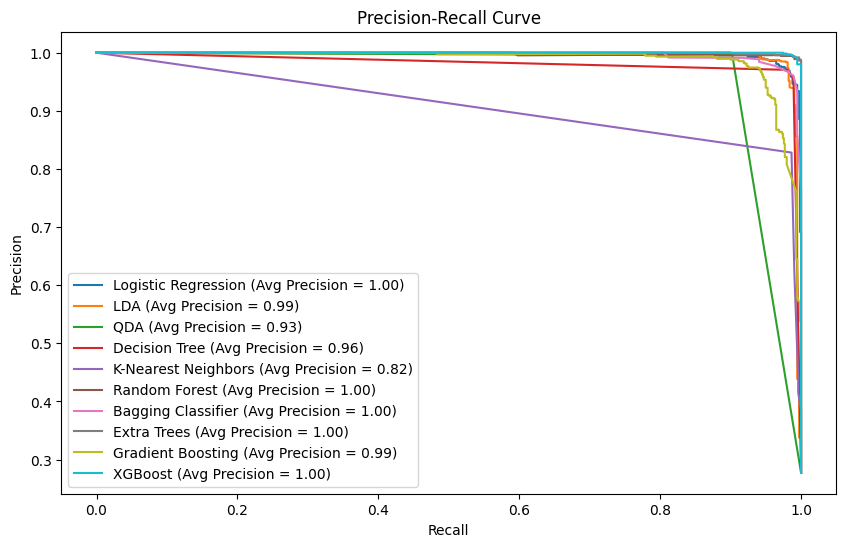

In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Plotting ROC curve for each model
plt.figure(figsize=(10, 6))
for name, model in models.items(): #Looping through the different models and performing the appropriate steps
    y_score = model.predict_proba(X_test)[:, 1] #Using predict_proba to get class probabilities
    fpr, tpr, _ = roc_curve(y_test, y_score) #FItting the roc_curve with the associateed y test and score variables
    roc_auc = auc(fpr, tpr) #fitting the auc function again with the appropriate fpr and tpr
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})') #Plotting based on the values of auc at two point precision
#Plotting everything based on the code we have thus far
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plotting Precision-Recall curve for each model by looping through everything and including the avg-precision, y-score, etc. 
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)
    plt.plot(recall, precision, label=f'{name} (Avg Precision = {avg_precision:.2f})')
#Setting appropriate labels and plotting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


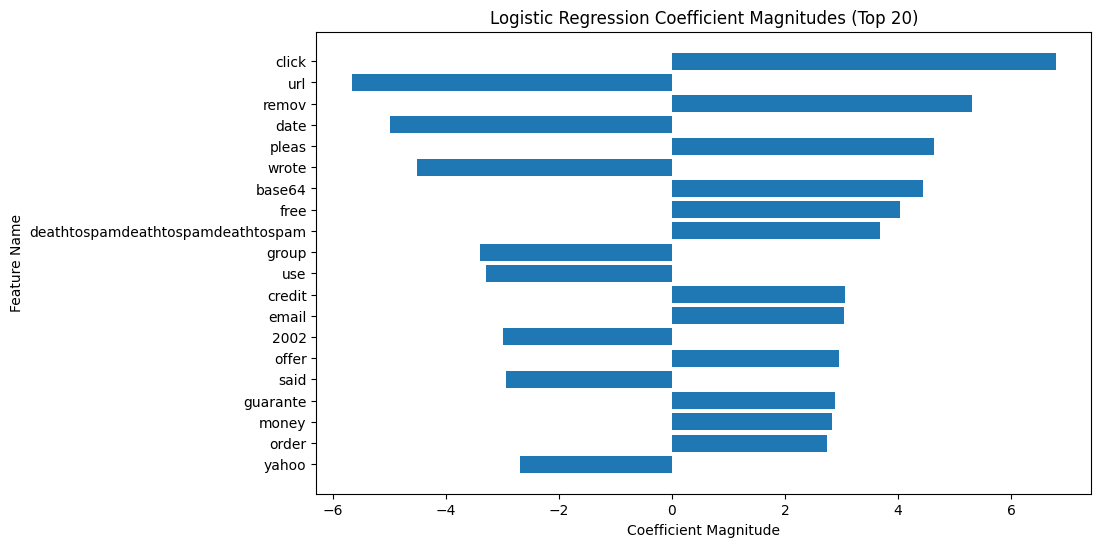

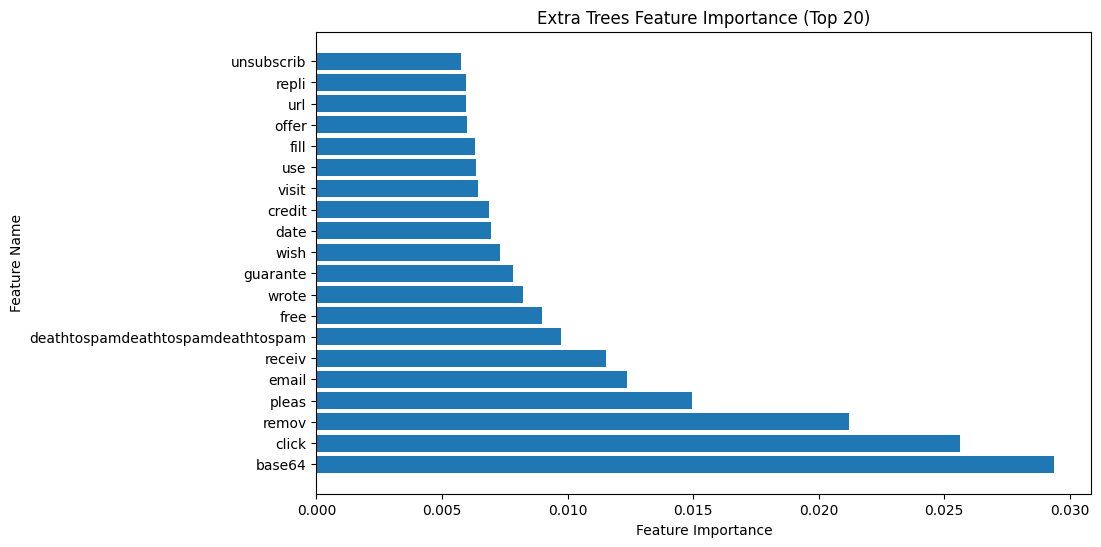

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Fit logistic regression model
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)

# Obtain coefficients and feature names
coefficients = logistic_regression_model.coef_[0]
feature_names = tfidf.get_feature_names_out()

# Get indices of top 20 features with highest coefficients
top_indices = np.argsort(np.abs(coefficients))[-20:]

# Plot coefficient magnitudes for top 20 features
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[top_indices], coefficients[top_indices])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature Name')
plt.title('Logistic Regression Coefficient Magnitudes (Top 20)')
plt.show()

# For Extra Trees feature importance
extra_trees_model = models['Extra Trees']
extra_trees_model.fit(X_train, y_train)

# Plot feature importance for Extra Trees
plt.figure(figsize=(10, 6))
feature_importances = extra_trees_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_features = 20  # Change as needed
plt.barh(feature_names[sorted_indices[:top_features]], feature_importances[sorted_indices][:top_features])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Extra Trees Feature Importance (Top 20)')
plt.show()





